In [69]:
import tables
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.fftpack import idst, dst
import cv2
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.layers import *
import datetime
from utils import *
import os
import shutil
import sys
import scipy

In [70]:
import nengo_dl
import nengo

In [71]:
from scipy.fftpack import idst,dst
type = 2
def denom_matrix(n_row,n_col):
    x = np.linspace(1, n_col, n_col)
    y = np.linspace(1, n_row,n_row)
    xv, yv = np.meshgrid(x, y)

    return np.transpose(((2*np.cos(np.pi*xv/(n_col+1))-2) + (2*np.cos(np.pi*yv/(n_row+1)) - 2)).flatten()) 

def DST_matrix(h,w,dim ='row'): 
    if(dim == 'row'):
        d = dst(np.eye(h), axis=0,type = type)
        return np.kron(np.eye(w),d)
    else:
        d = dst(np.eye(w), axis=0,type = type)
        return np.kron(np.eye(h),d)   

def IDST_matrix(h,w,dim ='row'): 
    if(dim == 'row'): 
        d = idst(np.eye(h), axis=0,type = type)
        return np.kron(np.eye(w),d)
    else:
        d = idst(np.eye(w), axis=0,type = type)
        return np.kron(np.eye(h),d)

def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1J / N )
    W = np.power( omega, i * j ) / np.sqrt(N)
    return W 

def transform_2d(n_row,n_col):
    n = np.arange(0,n_row*n_col)
    
    w = np.zeros((n_row*n_col,n_row*n_col))
    n1 = np.transpose(np.reshape(n,(n_row,n_col))).flatten()
    j = 0
    for i in n1:        
        w[i,j] = 1
        j = j+1
    return w.T 



def DST_matrix_s(h,w,dim ='row'): 
    if(dim == 'row'):
        d = dst(np.eye(h), axis=0,type = type)
        return scipy.sparse.kron(scipy.sparse.eye(w),d)
        
    else:
        d = dst(np.eye(w), axis=0,type = type)
        return scipy.sparse.kron(scipy.sparse.eye(h),d)
        
def IDST_matrix_s(h,w,dim ='row'): 
    if(dim == 'row'): 
        d = idst(np.eye(h), axis=0,type = type)
        return scipy.sparse.kron(scipy.sparse.eye(w),d)
        
    else:
        d = idst(np.eye(w), axis=0,type = type)
        return scipy.sparse.kron(scipy.sparse.eye(h),d)
        

def create_weights(h,w):
    tr_2d = transform_2d(h,w)
    w_dst_r = DST_matrix_s(h,w)
    w_dst_c = DST_matrix_s(h,w,dim='col')
    w_idst_r = IDST_matrix_s(h,w)
    w_idst_c = IDST_matrix_s(h,w,dim='col')
    w_dem = denom_matrix(h,w) 
    W =  tr_2d.T @ w_idst_r @ tr_2d @ w_idst_c @ np.diag((1/w_dem)) @ tr_2d.T @ w_dst_r @ tr_2d @ w_dst_c
    del tr_2d,w_dst_r,w_dst_c,w_idst_c,w_idst_r,w_dem 
    W = W - np.min(W)
    W = W/np.max(W)
    return W

In [74]:
inp = tf.keras.Input(shape=(90, 120, 6))

# convolutional layers

conv0 = tf.keras.layers.Conv2D(
    filters=3,
    kernel_size=3,
    padding='same',
    activation=tf.nn.relu,
)(inp)

conv1 = tf.keras.layers.Conv2D(
    filters=3,
    kernel_size=3,
    padding='same',
    activation=tf.nn.relu,
)(conv0)

conv2 = tf.keras.layers.Conv2D(
    filters=3,
    kernel_size=1,
    padding='same',
    activation=tf.nn.relu,
)(conv1)

conv3 = tf.keras.layers.Conv2D(
    filters=3,
    kernel_size=1,
    padding='same',
    activation=tf.nn.relu,
)(conv2)

conv4 = tf.keras.layers.Conv2D(
    filters=1,
    kernel_size=1,
    padding='same',

)(conv3)



model = tf.keras.Model(inputs=inp, outputs=conv4)

In [82]:
# load weights
model.load_weights("./traind_models/best_model_simple_6_fixed_model5.h5")
model.build((None, 90, 120, 6))


In [77]:
# load test data
y = np.load('./data/testy.npy')
X = np.load('./data/testX.npy')


In [97]:

valid_images = X.reshape((X.shape[0],1, -1))
valid_labels = y.reshape((y.shape[0],1,-1))
print(valid_images.shape)
print(valid_labels.shape)

(1306, 1, 64800)
(1306, 1, 10800)


In [79]:
h,w = (90,120)
W = create_weights(h,w)
W.shape

(10800, 10800)

In [104]:


n = h*w
n_neurons_ens = 10



def filling_in_network():
    
    with nengo.Network() as net:

          net.input = nengo.Node(size_in=n)
            

          layer = nengo.networks.EnsembleArray(n_neurons_ens, n,
                                                  neuron_type= nengo.SpikingRectifiedLinear()
                                                  )


          net.output = nengo.networks.EnsembleArray(n_neurons_ens, n,
                                                  neuron_type= nengo.SpikingRectifiedLinear()
                                                  )

          nengo.Connection(net.input,layer.input)

          nengo.Connection(layer.output,net.output.output,transform=(1-W))
     


    return net




In [105]:
present_time = 0.1
nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
        scale_firing_rates=100,
        synapse=0.01,
    )

with nengo_dl.Simulator(nengo_converter.net) as nengo_sim:
    nengo_sim.save_params('./save_model/keras_to_snn_params_caltech_albert_small')
    nengo_sim.load_params('./save_model/keras_to_snn_params_caltech_albert_small')
    nengo_sim.freeze_params(nengo_converter.net)
print(nengo_converter.net.n_neurons)

with nengo_converter.net:
  # Modify the `inp` node to present the MNIST images. We need to do this since the
  # default is to just output zeros
    nengo_converter.inputs[inp].output = nengo.processes.PresentInput(
      valid_images, presentation_time=present_time
  )

  # create references to the output layer of the converter network.
  # Note that we are not using `nengo_converter.outputs[dense]` here, since that is
  # just a nengo.Probe created by the converter. What we want is the actual
  # output layer, which in this case is `dense`.
    nengo_converter.net.output = nengo_converter.layers[conv4]


with nengo_converter.net:
    
  # add in the inverter network
    filling_in = filling_in_network()
   # filling_in = filling_in_unsharp_network()
  # make the connection from the output of the converter network to the input
  # of the inverter network
    nengo.Connection(nengo_converter.net.output, filling_in.input,transform = -8)

  # add probes for demonstration purposes
    convert_out_probe = nengo.Probe(nengo_converter.net.output, synapse=0.01)
    filling_in_out_probe = nengo.Probe(filling_in.output.output, synapse=0.01)
print(nengo_converter.net.n_neurons)   

|#                     Building network (3%)                     | ETA: 0:00:06

/home/jupyter/.local/lib/python3.7/site-packages/nengo_dl/simulator.py:461: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
129600
237600


In [106]:
import nengo_ocl
runtime = 20 * present_time
#with nengo_ocl.Simulator(nengo_converter.net) as sim:
with nengo.Simulator(nengo_converter.net) as sim:
    sim.run(runtime)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

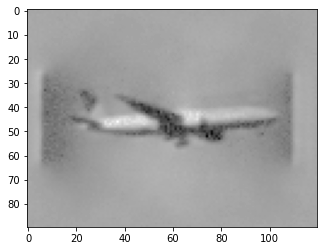

In [102]:
sim.data[filling_in_out_probe].shape
plt.imshow(np.reshape(sim.data[filling_in_out_probe][199],(h,w)),cmap='gray')

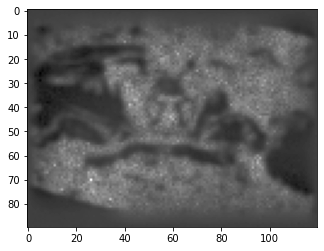

In [42]:
#100
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
fig = plt.figure()
imgs = []
for i in range(20*100):
    
    img = plt.imshow(np.reshape(sim.data[filling_in_out_probe][i],(h,w)), animated=True,cmap='gray')
    
    imgs.append([img])

ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_html5_video())

In [46]:
ani.save('result_model5_90_120.mp4')

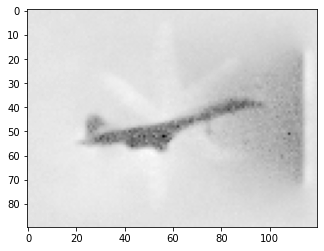

In [21]:
def solve_poisson(img_grad,isShow=False):
    type = 2
    if(len(img_grad.shape) == 3):
        x = img_grad[:,:,0]
    else:
        x = img_grad    
    h,w = x.shape
    w_dem = denom_matrix(h,w)    
    
    z = dst(dst(x,type=type,axis=0).T,type=type,axis=0).T
    d = np.reshape((1/(w_dem)),(h,w)) *  (z)
    p = idst(idst(d,type=type,axis=0).T,type=type,axis=0).T
    if isShow:
        plt.imshow(np.reshape(p,(h,w)),cmap='gray')
        plt.show()
    return p

def norm_image(img):
    img = img-np.min(img)
    return img/np.max(img)